In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from scipy.misc import imread

import tensorflow as tf

import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import sys
sys.path.append('./utils')

In [3]:
train_path = "./dataset/train/"

In [4]:
from load_labels import LoadLabels

train_labels, label_names, reverse_train_labels = LoadLabels('./dataset/train.csv').load_labels()

In [5]:
from partition_data import PartitionData
partitionData = PartitionData(train_labels)

In [6]:
partitions = partitionData.RepeatedMultilabelStratifiedKFold(3,1,420)

In [7]:
from model_parameter import ModelParameter
from image_preprocessor import ImagePreprocessor
from baseline_model import BaseLineModel
from train_model import train_model
from f1_score import base_f1
from keras.utils import multi_gpu_model

Using TensorFlow backend.


In [8]:
from keras import backend as K
'''
Compatible with tensorflow backend
'''
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(.25 * K.pow(1. - pt_1, 2.) * K.log(pt_1))-K.sum((1-.25) * K.pow( pt_0, 2.) * K.log(1. - pt_0))
    return focal_loss_fixed

In [9]:
class RandomizeImage(ImagePreprocessor):
    def __init__(self, modelparameter):
        super().__init__(modelparameter)
        
    def preprocess(self, image_id):
        image = self.load_image(image_id)
        image = self.resize(image)
        image = self.normalize(image)
        np.random.shuffle(image)
        return image

In [7]:
parameter = ModelParameter(train_path, shuffle=True, batch_size=256, n_channels=1, n_epochs=10, row_scale_factor=2, col_scale_factor=2)
preprocessor = ImagePreprocessor(parameter)
model = BaseLineModel(parameter, ['accuracy', focal_loss()])
model.build_model()
# model.model = multi_gpu_model(model.model, gpus=2, cpu_relocation=True)
model.compile_model(optimizer='Adam', loss=['categorical_crossentropy'])

In [11]:
predictions, histories = train_model(model, partitions, train_labels, train_path, parameter, preprocessor)

training in partition  1
Epoch 1/10
80/80 [==============================] - 261s 3s/step - loss: 5.0563 - acc: 0.3139 - focal_loss_fixed: inf - val_loss: 4.5132 - val_acc: 0.4139 - val_focal_loss_fixed: 2538.7010
Epoch 2/10
80/80 [==============================] - 230s 3s/step - loss: 4.5573 - acc: 0.3938 - focal_loss_fixed: inf - val_loss: 4.3113 - val_acc: 0.4143 - val_focal_loss_fixed: 1538.3622
Epoch 3/10
80/80 [==============================] - 231s 3s/step - loss: 4.2724 - acc: 0.4028 - focal_loss_fixed: inf - val_loss: 4.1884 - val_acc: 0.4137 - val_focal_loss_fixed: 1200.9849
Epoch 4/10
80/80 [==============================] - 232s 3s/step - loss: 3.9508 - acc: 0.4095 - focal_loss_fixed: inf - val_loss: 4.1805 - val_acc: 0.4142 - val_focal_loss_fixed: inf
Epoch 5/10
80/80 [==============================] - 232s 3s/step - loss: 3.6635 - acc: 0.4099 - focal_loss_fixed: inf - val_loss: 4.2634 - val_acc: 0.4138 - val_focal_loss_fixed: inf
Epoch 6/10
80/80 [========================

In [ ]:
scores = []
with tf.Session() as sess:
    for partition,prediction in zip(partitions,predictions):
        validation_labels = train_labels.loc[train_labels.Id.isin(partition["validation"])].copy()
        y_true = validation_labels.drop(["Id", "Target"], axis=1).values
        y_pred = np.where(prediction.values > 0.5, 1, 0)
        scores.append(sess.run(base_f1(y_true.flatten(), y_pred.flatten())))

In [13]:
print(scores)

[0.39559117, 0.64226216, 0.7807978]


partition  1


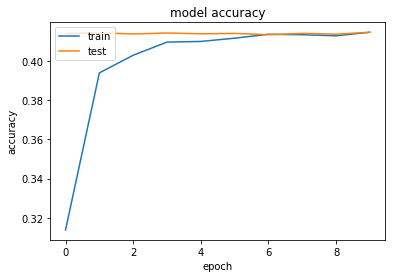

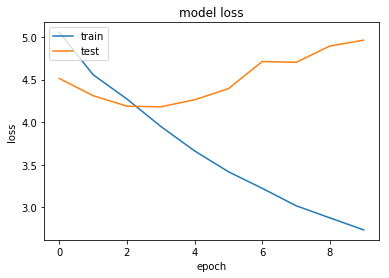

partition  2


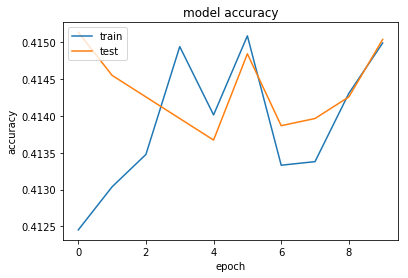

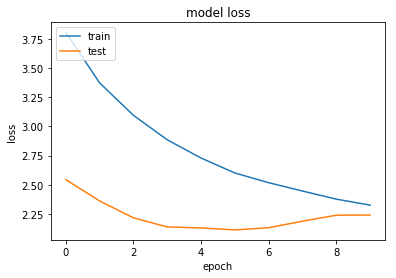

partition  3


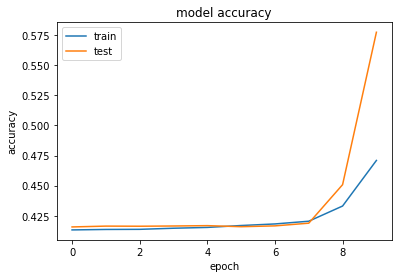

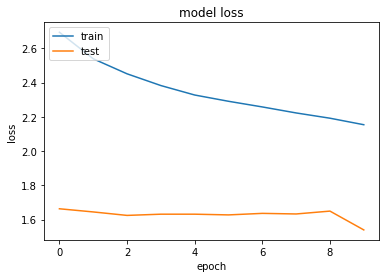

In [14]:
for i,history in enumerate(histories):
    print("partition ",i+1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [9]:
parameter = ModelParameter(train_path, shuffle=True, batch_size=256, n_channels=2, n_epochs=10, row_scale_factor=2, col_scale_factor=2)

In [10]:
preprocessor = ImagePreprocessor(parameter)

In [15]:
model_ch_2 = BaseLineModel(parameter, ['accuracy', focal_loss()])

In [19]:
model_ch_2.build_model()
model_ch_2.compile_model(optimizer='Adam', loss=['categorical_crossentropy'])
predictions_ch_2, histories_ch_2 = train_model(model_ch_2, partitions, train_labels, train_path, parameter, preprocessor)

training in partition  1
Epoch 1/10
80/80 [==============================] - 320s 4s/step - loss: 5.1249 - acc: 0.1876 - focal_loss_fixed: inf - val_loss: 4.4167 - val_acc: 0.0850 - val_focal_loss_fixed: 2783.5178
Epoch 2/10
80/80 [==============================] - 301s 4s/step - loss: 4.4272 - acc: 0.2739 - focal_loss_fixed: inf - val_loss: 4.1151 - val_acc: 0.4138 - val_focal_loss_fixed: 1480.7077
Epoch 3/10
80/80 [==============================] - 297s 4s/step - loss: 4.0079 - acc: 0.3435 - focal_loss_fixed: inf - val_loss: 4.0532 - val_acc: 0.4135 - val_focal_loss_fixed: 1276.0365
Epoch 4/10
80/80 [==============================] - 303s 4s/step - loss: 3.6056 - acc: 0.3897 - focal_loss_fixed: inf - val_loss: 4.0218 - val_acc: 0.4149 - val_focal_loss_fixed: inf
Epoch 5/10
80/80 [==============================] - 301s 4s/step - loss: 3.2881 - acc: 0.4069 - focal_loss_fixed: inf - val_loss: 4.1277 - val_acc: 0.4146 - val_focal_loss_fixed: inf
Epoch 6/10
80/80 [========================

In [ ]:
scores_ch_2 = []
with tf.Session() as sess:
    for partition,prediction in zip(partitions,predictions_ch_2):
        validation_labels = train_labels.loc[train_labels.Id.isin(partition["validation"])].copy()
        y_true = validation_labels.drop(["Id", "Target"], axis=1).values
        y_pred = np.where(prediction.values > 0.3, 1, 0)
        scores_ch_2.append(sess.run(base_f1(y_true.flatten(), y_pred.flatten())))
print(scores_ch_2)

partition  1


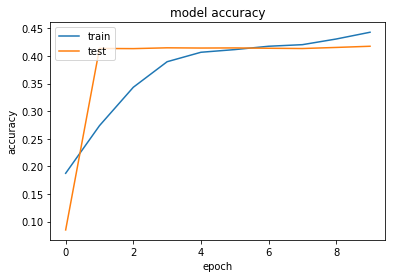

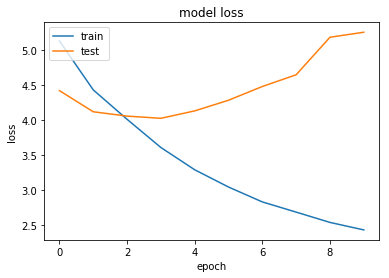

partition  2


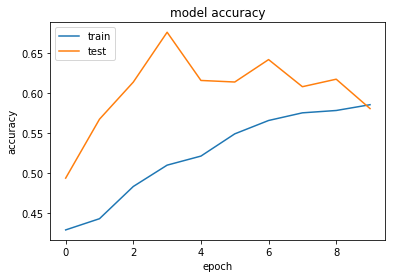

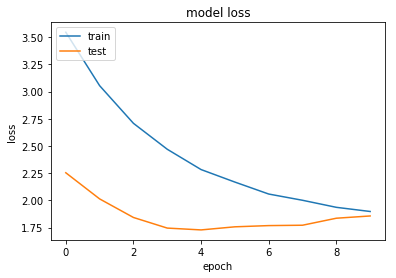

partition  3


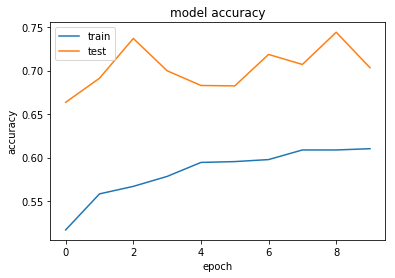

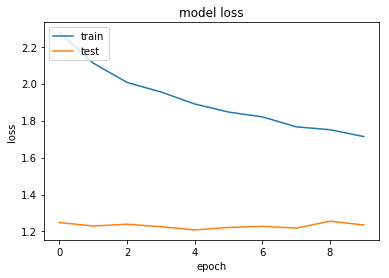

In [25]:
for i,history in enumerate(histories_ch_2):
    print("partition ",i+1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [26]:
parameter = ModelParameter(train_path, shuffle=True, batch_size=256, n_channels=3, n_epochs=10, row_scale_factor=2, col_scale_factor=2)

In [27]:
preprocessor = ImagePreprocessor(parameter)

In [28]:
model_ch_3 = BaseLineModel(parameter, ['accuracy', focal_loss()])

In [29]:
model_ch_3.build_model()
model_ch_3.compile_model(optimizer='Adam', loss=['categorical_crossentropy'])
predictions_ch_3, histories_ch_3 = train_model(model_ch_3, partitions, train_labels, train_path, parameter, preprocessor)

training in partition  1
Epoch 1/10
79/80 [============================>.] - ETA: 5s - loss: 5.0325 - acc: 0.2941 - focal_loss_fixed: inf Epoch 1/10
Epoch 1/10
80/80 [==============================] - 669s 8s/step - loss: 5.0306 - acc: 0.2945 - focal_loss_fixed: inf - val_loss: 4.4833 - val_acc: 0.4142 - val_focal_loss_fixed: inf
Epoch 2/10
80/80 [==============================] - 672s 8s/step - loss: 4.4515 - acc: 0.3149 - focal_loss_fixed: inf - val_loss: 4.1395 - val_acc: 0.4142 - val_focal_loss_fixed: inf
Epoch 3/10
80/80 [==============================] - 645s 8s/step - loss: 4.0878 - acc: 0.3438 - focal_loss_fixed: inf - val_loss: 4.0456 - val_acc: 0.4142 - val_focal_loss_fixed: inf
Epoch 4/10
80/80 [==============================] - 579s 7s/step - loss: 3.6706 - acc: 0.3707 - focal_loss_fixed: inf - val_loss: 4.0707 - val_acc: 0.4137 - val_focal_loss_fixed: inf
Epoch 5/10
80/80 [==============================] - 644s 8s/step - loss: 3.3383 - acc: 0.3859 - focal_loss_fixed: inf -

In [46]:
scores_ch_3 = []
with tf.Session() as sess:
    for partition,prediction in zip(partitions,predictions_ch_3):
        validation_labels = train_labels.loc[train_labels.Id.isin(partition["validation"])].copy()
        y_true = validation_labels.drop(["Id", "Target"], axis=1).values
        y_pred = np.where(prediction.values > 0.3, 1, 0)
        scores_ch_3.append(sess.run(base_f1(y_true.flatten(), y_pred.flatten())))
print(scores_ch_3)

[0.4239364, 0.7322507, 0.8481681]


partition  1


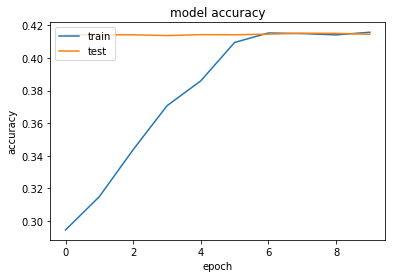

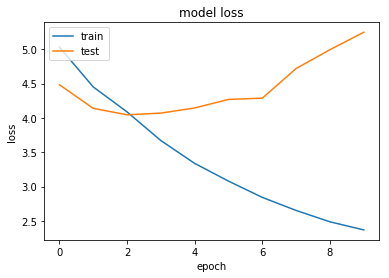

partition  2


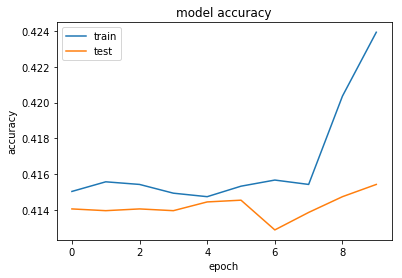

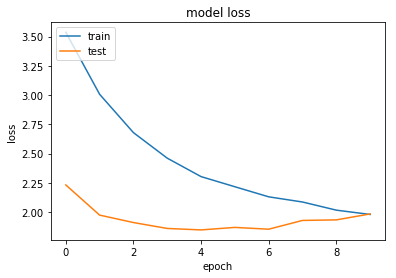

partition  3


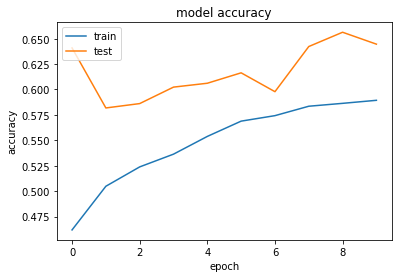

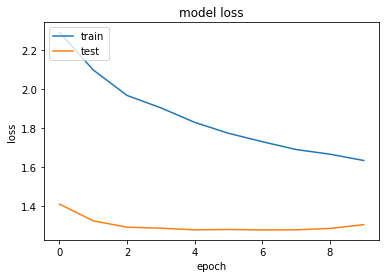

In [31]:
for i,history in enumerate(histories_ch_3):
    print("partition ",i+1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [11]:
parameter = ModelParameter(train_path, shuffle=True, batch_size=128, n_channels=3, n_epochs=5, row_scale_factor=2, col_scale_factor=2)

In [13]:
preprocessor = RandomizeImage(parameter)
model_rnd_ch_3 = BaseLineModel(parameter, ['accuracy'])
model_rnd_ch_3.build_model()
model_rnd_ch_3.compile_model()
predictions_rnd_ch_3, histories_rnd_ch_3 = train_model(model_rnd_ch_3, partitions, train_labels, train_path, parameter, preprocessor)

training in partition  1
Epoch 1/5
160/161 [============================>.] - ETA: 2s - loss: 4.7047 - acc: 0.1949Epoch 1/5
Epoch 1/5
161/161 [==============================] - 680s 4s/step - loss: 4.7018 - acc: 0.1954 - val_loss: 4.1491 - val_acc: 0.1767
Epoch 2/5
161/161 [==============================] - 342s 2s/step - loss: 4.2898 - acc: 0.3341 - val_loss: 4.0886 - val_acc: 0.4142
Epoch 3/5
161/161 [==============================] - 348s 2s/step - loss: 4.1723 - acc: 0.4045 - val_loss: 3.9236 - val_acc: 0.4144
Epoch 4/5
161/161 [==============================] - 336s 2s/step - loss: 4.0832 - acc: 0.4133 - val_loss: 3.9020 - val_acc: 0.4168
Epoch 5/5
161/161 [==============================] - 334s 2s/step - loss: 4.0196 - acc: 0.4144 - val_loss: 3.9009 - val_acc: 0.4163
training in partition  2
Epoch 1/5
161/161 [==============================] - 347s 2s/step - loss: 3.9869 - acc: 0.4100 - val_loss: 3.8459 - val_acc: 0.3965
Epoch 2/5
161/161 [==============================] - 342s 2

In [14]:
from f1_score import base_f1
scores_rnd_ch_3 = []
with tf.Session() as sess:
    for partition,prediction in zip(partitions,predictions_rnd_ch_3):
        validation_labels = train_labels.loc[train_labels.Id.isin(partition["validation"])].copy()
        y_true = validation_labels.drop(["Id", "Target"], axis=1).values
        y_pred = np.where(prediction.values > 0.5, 1, 0)
        scores_rnd_ch_3.append(sess.run(base_f1(y_true.flatten(), y_pred.flatten())))
print(scores_rnd_ch_3)

[0.40272507, 0.44013163, 0.46729678]


In [35]:
import keras.backend as K
K.clear_session() # removing session, it will instance another

In [10]:
from keras.utils import multi_gpu_model
from image_preprocessor import ImagePreprocessor
from model_parameter import ModelParameter
from baseline_model import BaseLineModel
parameter = ModelParameter(train_path, shuffle=True, batch_size=50, n_channels=1, n_epochs=10)
preprocessor = ImagePreprocessor(parameter)
model_max_ch_1 = BaseLineModel(parameter, ['accuracy',focal_loss()])
# with tf.device("/cpu:0"):
model_max_ch_1.build_model()
# model_max_ch_1.model = multi_gpu_model(model_max_ch_1.model, gpus=2, cpu_relocation=True)
model_max_ch_1.compile_model(optimizer='Adam', loss=['categorical_crossentropy'])

In [11]:
from train_model import train_model
predictions_max_ch_1, histories_max_ch_1 = train_model(model_max_ch_1, partitions, train_labels, train_path, parameter, preprocessor)

training in partition  1
Epoch 1/10
414/414 [==============================] - 1667s 4s/step - loss: 4.8853 - acc: 0.3252 - focal_loss_fixed: inf - val_loss: 4.2836 - val_acc: 0.4143 - val_focal_loss_fixed: 220.7948
Epoch 2/10
414/414 [==============================] - 1625s 4s/step - loss: 4.2372 - acc: 0.3869 - focal_loss_fixed: inf - val_loss: 4.1941 - val_acc: 0.4134 - val_focal_loss_fixed: 282.0524
Epoch 3/10
414/414 [==============================] - 1624s 4s/step - loss: 3.8063 - acc: 0.3996 - focal_loss_fixed: inf - val_loss: 4.2711 - val_acc: 0.4141 - val_focal_loss_fixed: inf
Epoch 4/10
414/414 [==============================] - 1627s 4s/step - loss: 3.3748 - acc: 0.4049 - focal_loss_fixed: inf - val_loss: 4.4810 - val_acc: 0.4139 - val_focal_loss_fixed: inf
Epoch 5/10
414/414 [==============================] - 1636s 4s/step - loss: 3.1086 - acc: 0.4112 - focal_loss_fixed: inf - val_loss: 4.5422 - val_acc: 0.4144 - val_focal_loss_fixed: inf
Epoch 6/10
414/414 [===============

In [57]:
model_max_ch_1.save("max_ch_1.h5")

In [58]:
for i,zp in enumerate(zip(partitions,predictions_max_ch_1)):
    partition, prediction = zp
    np.save("par_val_max_ch_1_"+str(i+1),partition['validation'])
    np.save('pred_val_max_ch_1_'+str(i+1),prediction)

In [40]:
scores_max_ch_1 = []
with tf.Session() as sess:
    for partition,prediction in zip(partitions,predictions_max_ch_1):
        validation_labels = train_labels.loc[train_labels.Id.isin(partition["validation"])].copy()
        y_true = validation_labels.drop(["Id", "Target"], axis=1).values
        y_pred = np.where(prediction.values > 0.3, 1, 0)
        scores_max_ch_1.append(sess.run(base_f1(y_true.flatten(), y_pred.flatten())))
print(scores_max_ch_1)

[0.37951612, 0.70391876, 0.80899274]


partition  1


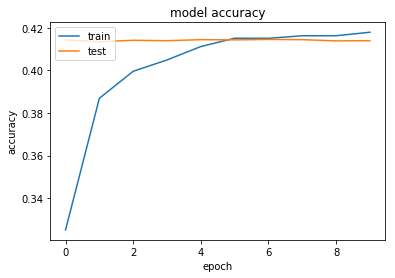

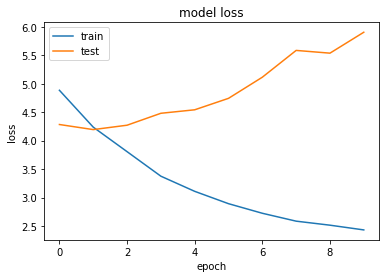

partition  2


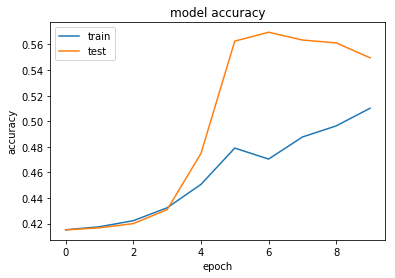

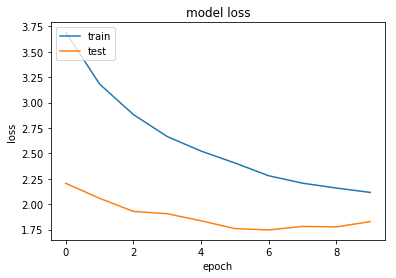

partition  3


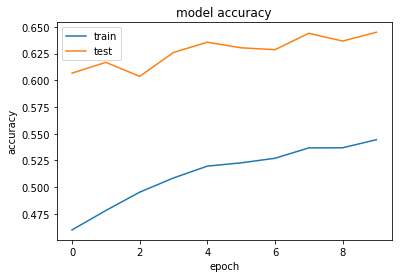

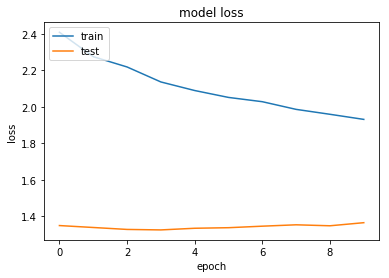

In [15]:
for i,history in enumerate(histories_max_ch_1):
    print("partition ",i+1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [10]:
parameter = ModelParameter(train_path, shuffle=True, batch_size=50, n_channels=2, n_epochs=50)
preprocessor = ImagePreprocessor(parameter)
model_max_ch_2 = BaseLineModel(parameter, ['accuracy', focal_loss()])
# with tf.device("/gpu:1"):
model_max_ch_2.build_model()
# model_max_ch_2.model = multi_gpu_model(model_max_ch_2.model, gpus=2, cpu_relocation=True)
model_max_ch_2.compile_model(optimizer='Adam', loss=['categorical_crossentropy'])

In [ ]:
from train_model import train_model
# with tf.device("/gpu:1"):
predictions_max_ch_2, histories_max_ch_2 = train_model(model_max_ch_2, partitions, train_labels, train_path, parameter, preprocessor)

training in partition  1
Epoch 1/50
 11/414 [..............................] - ETA: 56:06 - loss: 10.3558 - acc: 0.3327 - focal_loss_fixed: inf 

In [15]:
from f1_score import base_f1
scores_max_ch_2 = []
with tf.Session() as sess:
    for partition,prediction in zip(partitions,predictions_max_ch_2):
        validation_labels = train_labels.loc[train_labels.Id.isin(partition["validation"])].copy()
        y_true = validation_labels.drop(["Id", "Target"], axis=1).values
        y_pred = np.where(prediction.values > 0.3, 1, 0)
        scores_max_ch_2.append(sess.run(base_f1(y_true.flatten(), y_pred.flatten())))
print(scores_max_ch_2)

[0.41810042, 0.7233415, 0.9075934]


partition  1


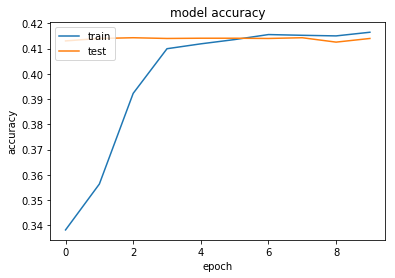

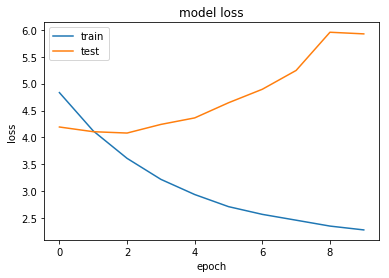

partition  2


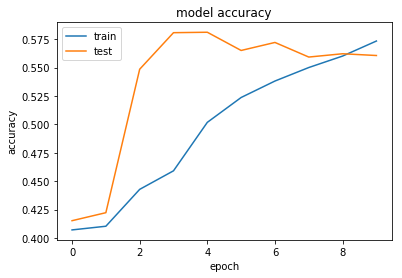

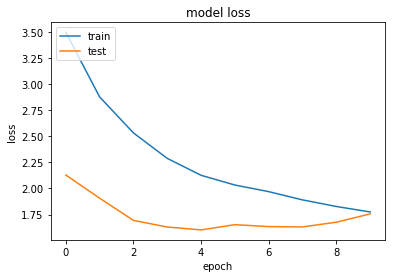

partition  3


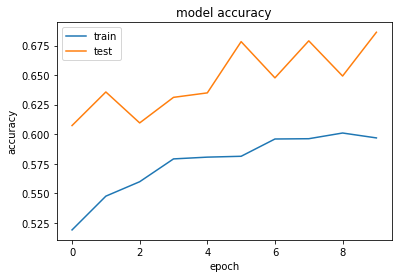

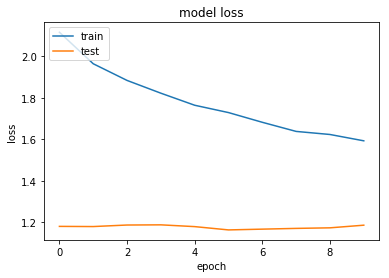

In [12]:
for i,history in enumerate(histories_max_ch_2):
    print("partition ",i+1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [13]:
model_max_ch_2.save("max_ch_2.h5")

In [16]:
np.save('hist_val_max_ch_2',histories_max_ch_2)

In [14]:
for i,zp in enumerate(zip(partitions,predictions_max_ch_2)):
    partition, prediction = zp
    np.save("par_val_max_ch_2_"+str(i+1),partition['validation'])
    np.save('pred_val_max_ch_2_'+str(i+1),prediction)

In [123]:
parameter = ModelParameter(train_path, shuffle=True, batch_size=50, n_channels=3, n_epochs=70)
preprocessor = ImagePreprocessor(parameter)
model_max_ch_3 = BaseLineModel(parameter, ['accuracy', focal_loss()])
# with tf.device("/gpu:1"):
model_max_ch_3.build_model()
# model_max_ch_3.model = multi_gpu_model(model_max_ch_3.model, gpus=2, cpu_relocation=True)
model_max_ch_3.compile_model(optimizer='Adam', loss=['categorical_crossentropy'])

In [ ]:
predictions_max_ch_3, histories_max_ch_3 = train_model(model_max_ch_3, partitions, train_labels, train_path, parameter, preprocessor)

training in partition  1
Epoch 1/70


In [17]:
from f1_score import base_f1
scores_max_ch_3 = []
with tf.Session() as sess:
    for partition,prediction in zip(partitions,predictions_max_ch_3):
        validation_labels = train_labels.loc[train_labels.Id.isin(partition["validation"])].copy()
        y_true = validation_labels.drop(["Id", "Target"], axis=1).values
        y_pred = np.where(prediction.values > 0.30, 1, 0)
        scores_max_ch_3.append(sess.run(base_f1(y_true.flatten(), y_pred.flatten())))
print(scores_max_ch_3)

[0.42110237, 0.7607349, 0.84431624]


partition  1


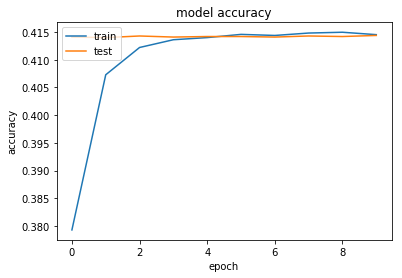

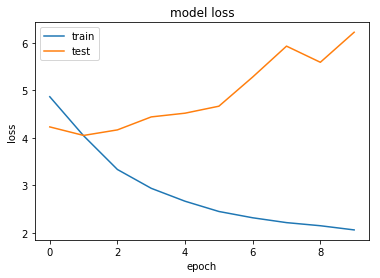

partition  2


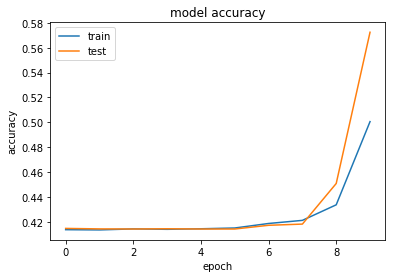

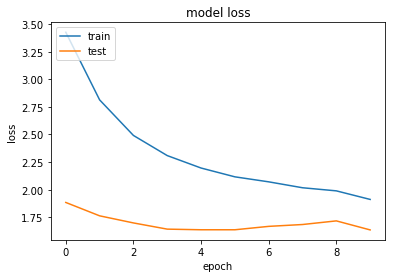

partition  3


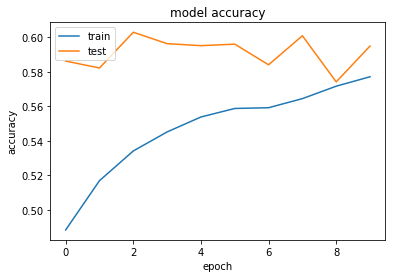

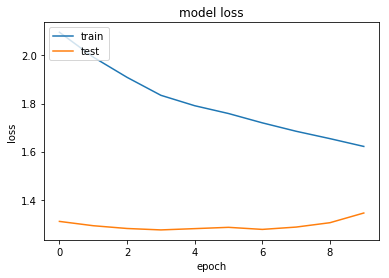

In [23]:
for i,history in enumerate(histories_max_ch_3):
    print("partition ",i+1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [13]:
model_max_ch_3.save("max_ch_3.h5")

In [18]:
for i,zp in enumerate(zip(partitions,predictions_max_ch_3)):
    partition, prediction = zp
    np.save("par_val_max_ch_3_"+str(i+1),partition['validation'])
    np.save('pred_val_max_ch_3_'+str(i+1),prediction)

In [21]:
np.save('hist_val_max_ch_3',histories_max_ch_3)

In [103]:
from generators import PredictGenerator
submission = pd.read_csv("./dataset/sample_submission.csv")
test_path = "./dataset/test/"
test_names = submission.Id.values
test_labels = pd.DataFrame(data=test_names, columns=["Id"])
for col in train_labels.columns.values:
    if col != "Id":
        test_labels[col] = 0
test_parameter = ModelParameter(test_path, shuffle=True, batch_size=50, n_channels=3, n_epochs=10)
test_preprocessor = ImagePreprocessor(test_parameter)
submission_predict_generator = PredictGenerator(test_names, test_preprocessor, test_path)

In [104]:
submission_proba_predictions = model_max_ch_3.predict(submission_predict_generator)
baseline_labels = test_labels.copy()
baseline_labels.loc[:, test_labels.drop(["Id", "Target"], axis=1).columns.values] = submission_proba_predictions
baseline_labels.to_csv("baseline_submission_proba.csv")

In [105]:
reverse_train_labels = dict((v,k) for k,v in label_names.items())

In [106]:
def transform_to_target(row):
    target_list = []
    for col in baseline_labels.drop(["Target"], axis=1).columns:
        if row[col] == 1:
            target_list.append(str(reverse_train_labels[col]))
    if len(target_list) == 0:
        return str(0)
    return " ".join(target_list)

In [119]:
improved_submission = baseline_labels.copy()
for column in improved_submission.drop(['Id','Target'],axis=1).columns.values:
    improved_submission.loc[:,column] = np.where(improved_submission.loc[:,column]>=0.2,1,0)
improved_submission.head(2)

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [120]:
improved_submission["Predicted"] = improved_submission.apply(lambda l: transform_to_target(l), axis=1)

In [121]:
submission = improved_submission.loc[:, ["Id", "Predicted"]]
submission.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 21 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 21 23 25


In [122]:
submission.to_csv("test_model_max_ch_3_02.csv", index=False)

In [99]:
from generate_test_csv import gen_test
test_parameter = ModelParameter(test_path, shuffle=True, batch_size=50, n_channels=3, n_epochs=10)
test_preprocessor = ImagePreprocessor(test_parameter)

In [100]:
gen_test(train_labels, test_parameter, test_preprocessor, model_max_ch_3, 'model_max_ch_3', label_names, )

NameError: name 'pd' is not defined